# 11. Collaborative Filtering - Deep Learning
## Neural Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
import scipy as sp
import tensorflow as tf
from keras.layers import Embedding, Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.models import Sequential, Model
import keras
from keras import layers
# from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
# Check if GPU is available
# print(tf.config.list_physical_devices('GPU'))

In [2]:
%run "01.Recommendation_Loading.ipynb"

################  Recommendations (all data, positive recommendations only) ################
Users: 12,663,134
Games: 37,419
Number of users 2,000
First five users id [11187923 12792392 11703922  9531989 11022607]
################  Recommendations (Sample) ################
Minimum number of recommendations to be included in the sample: 20
Number of randomly selected users: 2000
Users: 1,991
Games: 11,366
################ User-Game Matrix ################
Number of Rows: 1,992
Numbeer of Columns: 11,367
Number of stored values: 74,405


In [3]:
recommendations.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,user_id_categorical,app_id_categorical
38767195,337000,19,6,2021-07-11,1,26.0,12039,38767195,0,2500
5429077,381210,0,0,2021-10-20,1,10.0,12039,5429077,0,3122
5714345,1144200,2,0,2022-11-28,1,15.9,12039,5714345,0,8576
5155342,292030,0,0,2021-10-29,1,7.8,12039,5155342,0,1894
38565974,15120,7,0,2020-05-22,1,17.0,12039,38565974,0,238


In [4]:
%run "Get_Training_and_Test_Instances.ipynb"

################  Get Test Data ################
x_test.shape: (1991, 2)
y_test.shape: (1991, 1)
Number of Users: 1,992
Number of Games: 11,367
Number of Negatives Sample per User-Game: 2
################  Get Training Data ################


C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_23072\520038405.py:7: FutureWarning: The provided callable <function nanmax at 0x000001F72B9AACA0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_df = df.groupby("user_id_categorical").agg({"date": np.nanmax}).reset_index()
C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_23072\520038405.py:9: FutureWarning: The provided callable <function nanmax at 0x000001F72B9AACA0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  rec_df = df.groupby("user_id_categorical").agg({"app_id_categorical": np.nanmax}).reset_index()


x_train.shape: (222222, 2)
y_train.shape: (222222, 2)


## Create the model

In [10]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, num_units_layers, learning_rate=0.001,  **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        # embeddings reduce the dimensionality, they are like look up tables
        self.user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
        self.item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim= int(num_units_layers[0]/2), # embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        
        self.game_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim= int(num_units_layers[0]/2), # embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.flatten_users = layers.Flatten()
        self.flatten_games = layers.Flatten()
        self.concat_users_games = layers.Concatenate()
        self.dense_layer_1 = layers.Dense(
            units = num_units_layers[0],
            activation = "relu",
            kernel_initializer="glorot_uniform",
            activity_regularizer=tf.keras.regularizers.L2(0.01),
            # kernel_regularizer=tf.keras.regularizers.L1(0.01)
        )
        self.dense_layer_2 = layers.Dense(
            units = num_units_layers[1],
            activation = "relu",
            kernel_initializer="glorot_uniform",
            activity_regularizer=tf.keras.regularizers.L2(0.001),
            # kernel_regularizer=tf.keras.regularizers.L1(0.01)
        )
        self.prediction = layers.Dense(
            units = 1,
            activation = "sigmoid",
            input_dim = num_units_layers[1]
        )


    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])
        game_vector = self.game_embedding(inputs[:,1])
        users_flat = self.flatten_users(user_vector)
        games_flat = self.flatten_games(game_vector)
        concat = self.concat_users_games([users_flat, games_flat])
        dense_layer_1 = self.dense_layer_1(concat)
        dense_layer_2 = self.dense_layer_2(dense_layer_1)
        prediction = self.prediction(dense_layer_2)
        return prediction 

model = RecommenderNet(num_users, num_items, [40,20])
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adagrad suited for sparse data
)

c:\Users\riccardoricci\.conda\envs\NCF\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Model Training**

In [6]:
epochs=15
n_users2val = 100
K = 10
num_users, num_games = user_game_matrix.shape

In [11]:
def train_model():
    
    train_loss = []
    validation_loss = []
    avg_precision_train = []
    avg_recall_train = []
    hgr_test = []
    
    for epoch in np.arange(epochs):
        print("########################################## Epoch:", epoch, "###########################################")
        history = model.fit(
        x=x_train, # user_idx and app_idx
        y=y_train, # 1 or 0
        #batch_size=64, # Number of samples per gradient update aka Minibatch Gradient Descent
        epochs=1, # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
        verbose=1, # progress line
        validation_data=(x_test, y_test) # Data on which to evaluate the loss and any model metrics at the end of each epoch  
        )

        train_loss.append(history.history["loss"])
        validation_loss.append(history.history["val_loss"])
        print("#################### Training Data ####################")

        prec, rec = eval_k_avg(n_users2val, K, num_users, num_games, x_train, y_train)
        print("Number of users:", n_users2val)
        print("K:",K)
        print("Average Precision", '{0:.4%}'.format(prec))
        print("Average Recall", '{0:.4%}'.format(rec))
        avg_precision_train.append(prec)
        avg_recall_train.append(rec)
        print("#################### Test Data ####################")

        # hit_r = eval_hit_ratio(n_users2val, K, num_games, x_test)
        hit_r = eval_hit_ratio(n_users2val, K, num_games, 100, x_train, x_test)
        hgr_test.append(hit_r)
        print("Number of users:", n_users2val)
        print("K:",K)
        print("Hit Gain Ratio:", '{0:.4%}'.format(hit_r))
    
    return train_loss, validation_loss, avg_precision_train, avg_recall_train, hgr_test
        
# train_model()    

**Hyper Parameter Tuning**

Number of Neurons in layers

In [12]:
layers_list = [[10, 5], [20, 10], [40,20], [80, 40]]
layers_list

[[10, 5], [20, 10], [40, 20], [80, 40]]

In [13]:
models_train_loss = []
models_val_loss = []
models_avg_precision_train = []
models_avg_recall_train = []
models_hgr_test = []

for i, lay in enumerate(layers_list):
    print("#######################################################################################################")
    print("########################################## MODEL:", i+1, "###################################################")
    print("#######################################################################################################")
    model = RecommenderNet(num_users, num_items, lay)
    model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adagrad suited for sparse data
    )
    train_loss, validation_loss, avg_precision_train, avg_recall_train, hgr_test = train_model()
    models_train_loss.append(train_loss)
    models_val_loss.append(validation_loss)
    models_avg_precision_train.append(avg_precision_train)
    models_avg_recall_train.append(avg_recall_train)
    models_hgr_test.append(hgr_test)
    

#######################################################################################################
########################################## MODEL: 1 ###################################################
#######################################################################################################
########################################## Epoch: 0 ###########################################
2284/6945 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.5945

KeyboardInterrupt: 

In [19]:
num_epochs = np.arange(1, epochs+1)

Model: 1
Number of Neurons [10, 5]


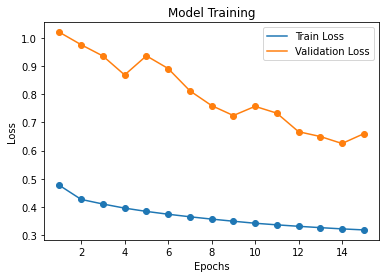

Model: 2
Number of Neurons [20, 10]


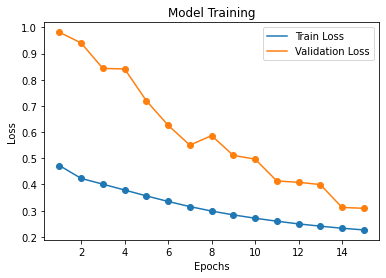

Model: 3
Number of Neurons [40, 20]


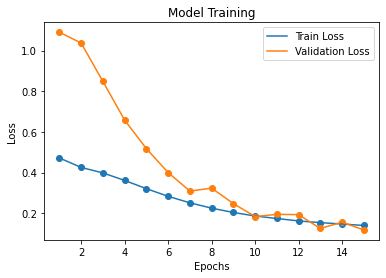

Model: 4
Number of Neurons [80, 40]


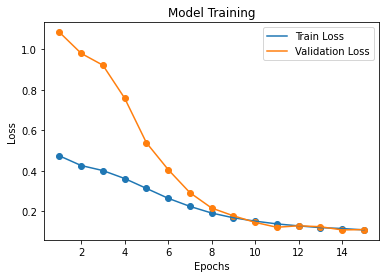

In [22]:
for i, m in enumerate(models_train_loss):
    print("Model:", i+1)
    print("Number of Neurons", layers_list[i])
    plt.plot(num_epochs, models_train_loss[i], label="Train Loss")
    plt.scatter(num_epochs, models_train_loss[i])
    plt.plot(num_epochs, models_val_loss[i], label="Validation Loss")
    plt.scatter(num_epochs, models_val_loss[i])
    plt.title("Model Training")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Model: 1
Number of Neurons [10, 5]


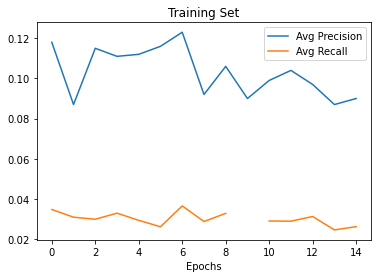

Model: 2
Number of Neurons [20, 10]


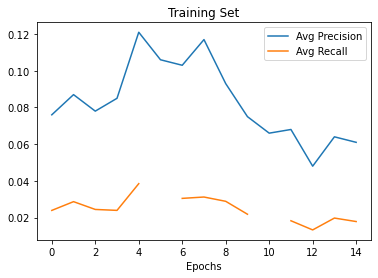

Model: 3
Number of Neurons [40, 20]


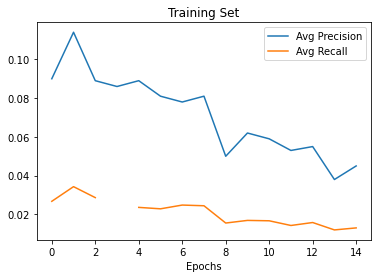

Model: 4
Number of Neurons [80, 40]


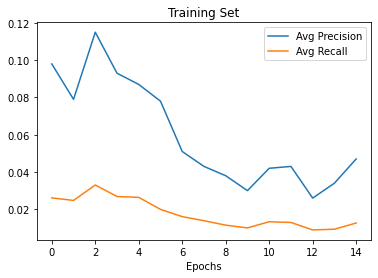

In [12]:
for i, m in enumerate(models_train_loss):
    print("Model:", i+1)
    print("Number of Neurons", layers_list[i])
    plt.plot(models_avg_precision_train[i], label='Avg Precision')
    plt.plot(models_avg_recall_train[i], label='Avg Recall')
    plt.title("Training Set")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

Model: 1
Number of Neurons [10, 5]


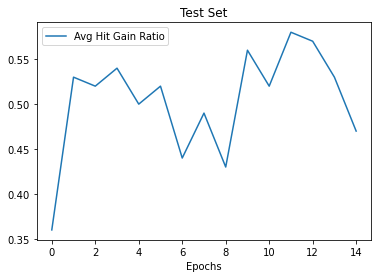

Model: 2
Number of Neurons [20, 10]


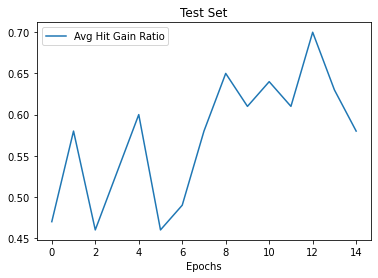

Model: 3
Number of Neurons [40, 20]


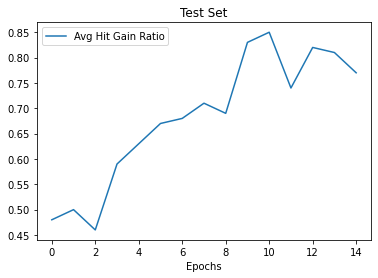

Model: 4
Number of Neurons [80, 40]


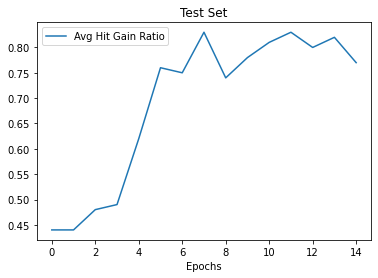

In [13]:
for i, m in enumerate(models_train_loss):
    print("Model:", i+1)
    print("Number of Neurons", layers_list[i])
    plt.plot(models_hgr_test[i], label='Avg Hit Gain Ratio')
    plt.title("Test Set")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

In [14]:
plt.plot(avg_prec_train, label='Avg Precision')
plt.plot(avg_recal_train, label='Avg Recall')
plt.title("Training Set")
plt.xlabel("Epochs")
plt.legend()
plt.show()

NameError: name 'avg_prec_train' is not defined

In [ ]:
plt.plot(hgr_test, label = 'Avg Hit Gain Ratio')
plt.legend()
plt.title("Test Set")
plt.xlabel("Epochs")
plt.show()